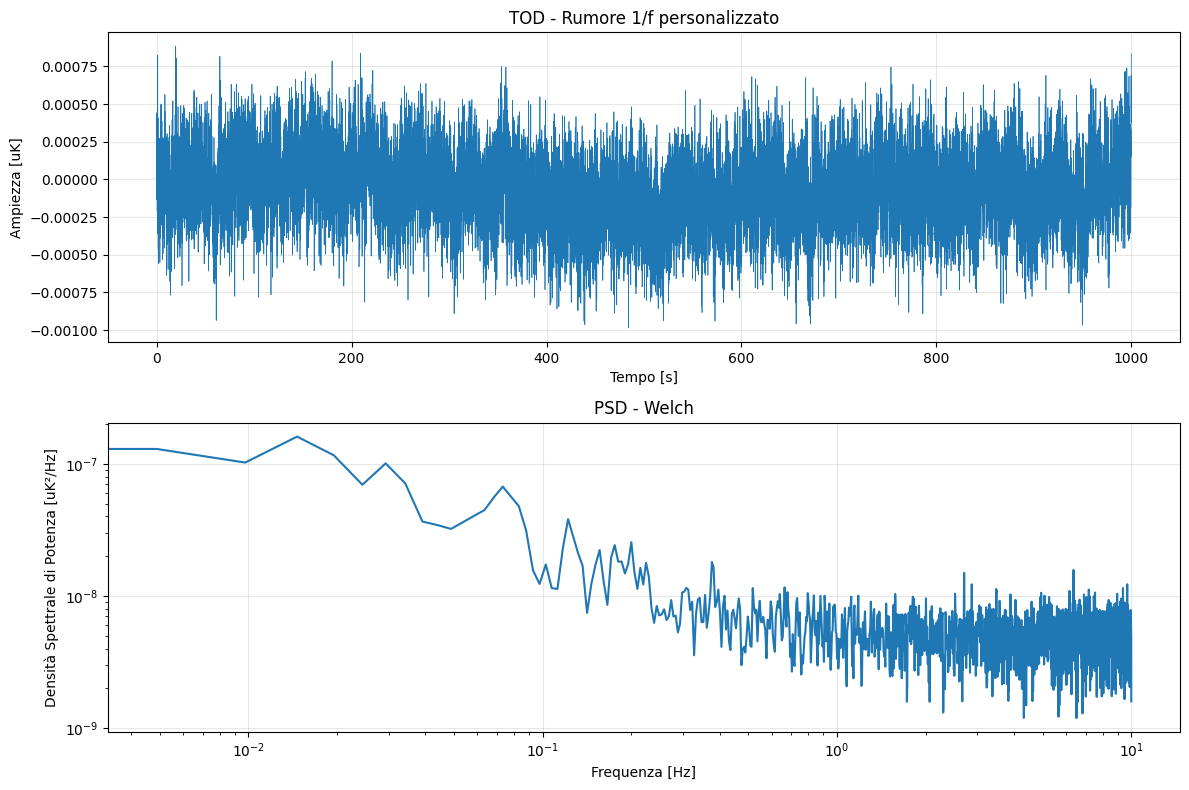

In [1]:
import litebird_sim as lbs
from astropy.time import Time
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import ducc0

start_time = 0
time_span_s = 1000.0
nside = 128

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=time_span_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) 
)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(0),
        precession_rate_hz=0,
        spin_rate_hz=1 / 60,
        start_time=start_time,
    ),
    delta_time_s=5.0,
)

sim.set_instrument(
    lbs.InstrumentInfo(
        boresight_rotangle_rad=0.0,
        spin_boresight_angle_rad=np.deg2rad(90),
        spin_rotangle_rad=np.deg2rad(75),
    )
)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.,
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.,
    fmin_hz=1e-5,
    alpha=1
)

sim.create_observations(detectors=det)


# Generazione rumore con OofaNoise:

n_samples = int(time_span_s * det.sampling_rate_hz)  # Numero totale di campioni

noise_gen = ducc0.misc.OofaNoise(
    sigmawhite=det.net_ukrts * 1e-6 * np.sqrt(det.sampling_rate_hz),   # Sigma del rumore bianco = NET*1e-6*radice(frequenza di campionamento)
    f_knee=det.fknee_mhz * 1e-3,                                       # Frequenza di knee (moltiplicarla per )
    f_min=det.fmin_hz,                                                 # Frequenza minima 
    f_samp=det.sampling_rate_hz,                                       # Frequenza di campionamento
    slope=-det.alpha                                                    # Pendenza tra f_min e f_knee 
)


np.random.seed(sim.random_seed) # importante per ripetibilità
# Rumore bianco gaussiano 
white_noise_input = np.random.normal(0., 1., (n_samples,))     # media=0 e deviazione standard=1

# Applicazione filtro
custom_noise = noise_gen.filterGaussian(white_noise_input)

# Aggiunta rumore al TOD
sim.observations[0].tod[0] += custom_noise
tod_data = sim.observations[0].tod[0]
# → sono uguali lo stati solo rinominando


# Calcolo PSD con Welch
frequencies, psd = welch(
    tod_data,
    fs=det.sampling_rate_hz,  # Frequenza di campionamento
    window='hann',            # Finestra di Hann per ridurre leakage
    nperseg=2**12,            # Lunghezza segmento (potenza di 2)
    noverlap=2**12 / 2,       # Overlap 50% per efficienza
    scaling='density',        # Densità spettrale di potenza
)


# PLOTTING
plt.figure(figsize=(12, 8))

# Plot 1: Segnale temporale
plt.subplot(2, 1, 1)
time_axis = np.arange(len(tod_data)) / det.sampling_rate_hz
plt.plot(time_axis, tod_data, linewidth=0.5)
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza [uK]')
plt.title('TOD - Rumore 1/f personalizzato')
plt.grid(True, alpha=0.3)

# Plot 2: Spettro di potenza
plt.subplot(2, 1, 2)
plt.loglog(frequencies, psd, linewidth=1.5)
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Densità Spettrale di Potenza [uK²/Hz]')
plt.title('PSD - Welch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()